<a href="https://colab.research.google.com/github/PRIMEADAWAS/CEB_Assignment/blob/main/RADI622_A2_PasitSupholkhan_(Assignment_Fourier_transform%2C_image_registration%2C_image_segmentation_and_morphological_image_processing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RADI622_A2_PasitSupholkhan (Assignment: Fourier transform, image registration, image segmentation and morphological image processing)

# Assignement 2 : RADI 622: Medical Image Processing

In [ ]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
print('Pandas version :',pd.__version__)
print('Numpy version :',np.__version__)
%matplotlib inline

Pandas version : 1.5.3
Numpy version : 1.22.4


# 2. When we apply fourier transform to the image A we get image B (Amplitude of frequency domain) (8 Point)



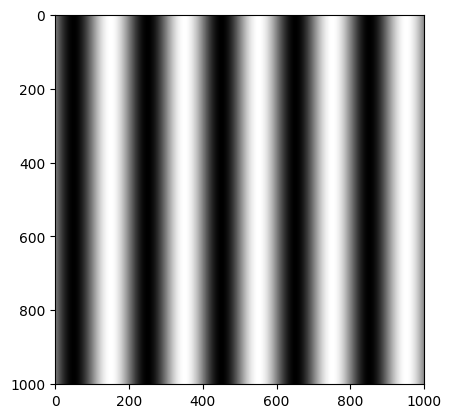

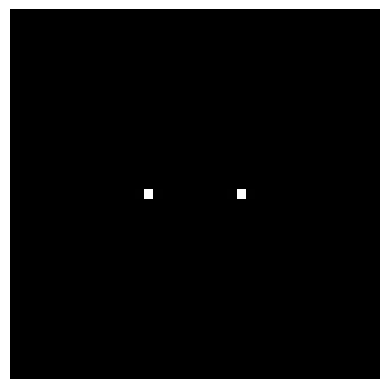

In [ ]:
x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
grating = np.sin(2* np.pi * X / wavelength)
plt.set_cmap("gray")
plt.imshow(grating)
plt.show()

ft = np.fft.fft2(grating)
ft = np.fft.fftshift(ft)

plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis('off')
plt.show()

It will show the mew white middle point between previous two points

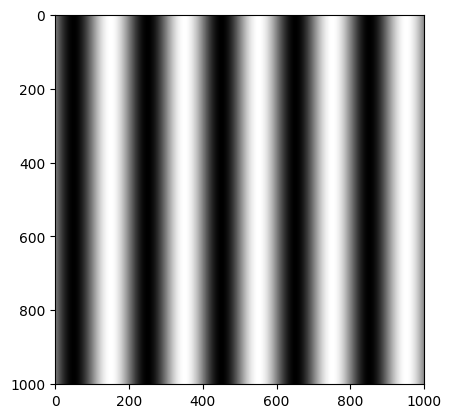

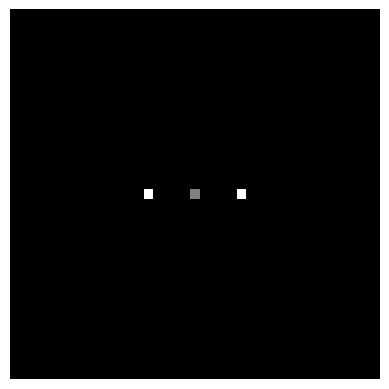

In [ ]:
x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
# add some X value
grating = np.sin(2* np.pi * X / wavelength) +0.25
plt.set_cmap("gray")
plt.imshow(grating)
plt.show()

ft = np.fft.fft2(grating)
ft = np.fft.fftshift(ft)

plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis('off')
plt.show()

In addition, the more high X value add to grating function. the more white of the middle point and the darker of the left and right point.

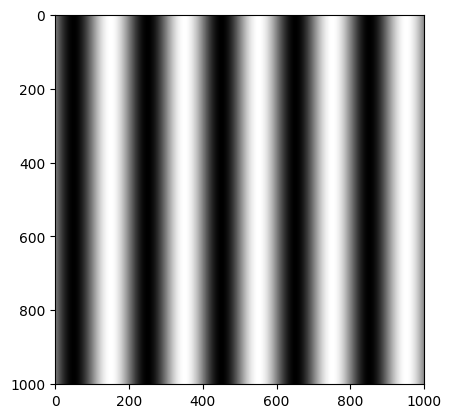

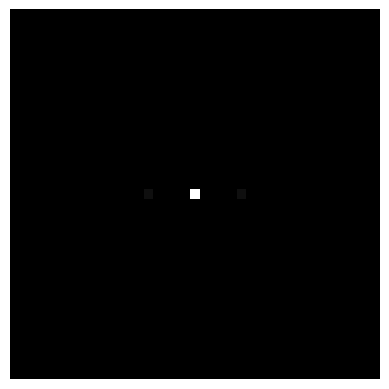

In [ ]:
x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
# add more X value
grating = np.sin(2* np.pi * X / wavelength) +8
plt.set_cmap("gray")
plt.imshow(grating)
plt.show()

ft = np.fft.fft2(grating)
ft = np.fft.fftshift(ft)

plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis('off')
plt.show()

# 4. Write simple code for aligning two images (your choice to choose two images freely) using either SimpleITK or SimpleElastix (easier to use than SimpleITK for image registration task) library.
  - 4.1 Align two images using linear transformation (16 point)
  - 4.2 Align two images using non-linear transformation (17 point)


In [ ]:
!pip install SimpleITK

In [ ]:
# create function for display comparison image registration
def displayRegistration(fixed_image_array,moving_image_array):
  plt.figure(figsize=(10,5))
  plt.gray()
  plt.subplot(131), plt.imshow(fixed_image_array), plt.axis('off'), plt.title('MRI-T1 Image', size=20)
  plt.subplot(132), plt.imshow(moving_image_array), plt.axis('off'), plt.title('MRI-T2 Image', size=20)
  plt.subplot(133), plt.imshow(0.6*fixed_image_array + 0.4*moving_image_array), plt.axis('off'), plt.title('Compare Alignment', size=20)
  plt.show()

before registration

(131, 127) (131, 127)


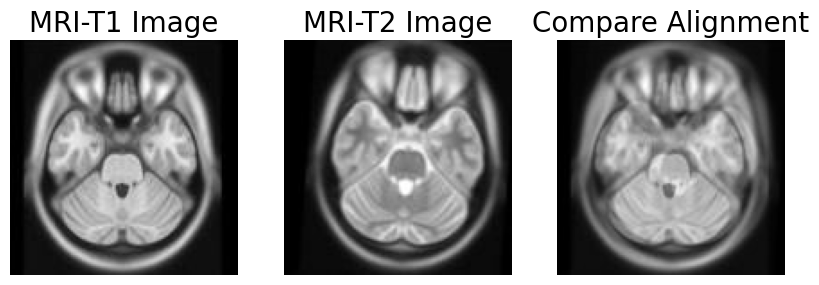

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

fixed_image =  sitk.ReadImage("MRIT1.jpg", sitk.sitkFloat32)
moving_image = sitk.ReadImage("MRIT2.jpg", sitk.sitkFloat32)

fixed_image_array = sitk.GetArrayFromImage(fixed_image)
moving_image_array = sitk.GetArrayFromImage(moving_image)
print(fixed_image_array.shape, moving_image_array.shape)

displayRegistration(fixed_image_array,moving_image_array)

translation to correct position

(131, 127) (131, 127)


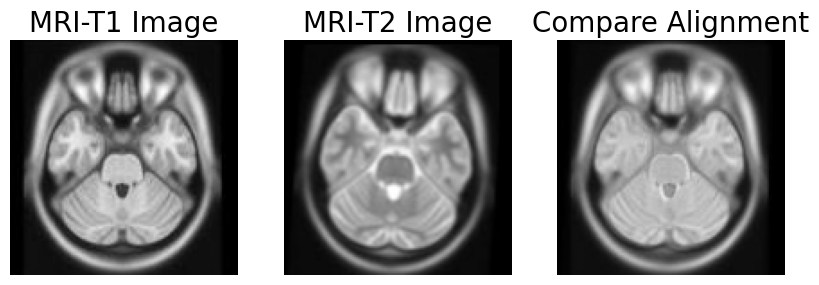

In [ ]:
# move the center of image
initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                      moving_image,
                                                      sitk.Similarity2DTransform())

default_pixel = 0.0
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, default_pixel, moving_image.GetPixelID())

fixed_image_array = sitk.GetArrayFromImage(fixed_image)
moving_image_array = sitk.GetArrayFromImage(moving_resampled)
print(fixed_image_array.shape, moving_image_array.shape)

displayRegistration(fixed_image_array,moving_image_array)

rotation to correct angle

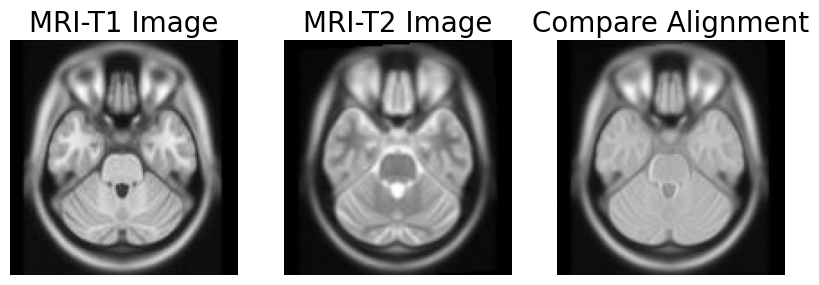

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

## Similarity metric settings.
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# set interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

default_pixel = 0.0
out = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, default_pixel, moving_image.GetPixelID())
moving_image_array = sitk.GetArrayFromImage(out)

displayRegistration(fixed_image_array,moving_image_array)

# 5. One of the common segmentation method is called grahcut. (10 points)
- 5.1 Please describe what is graphcut method.
- 5.2 Please explain the process of graphcut, how it works.
- 5.3 Please explain when to use graphcut and and its advantages and disadvantage.  
You can provide an answer by demonstrate the process in a form of coding as well. If so, please make sure to provide a clear explanation in the code as well.


**5.1 Please describe what is graphcut method.**  
Graphcut is image segmentation method that divides an image into foreground and background regions using graph theory and min-cut/max-flow algorithms. The method treats an image as a graph, with pixels representing nodes and connections between pixels (edges) assigned weights based on color, texture, or other image properties. The image is divided into two disjoint sets by finding the minimum cut in this graph: the foreground and background regions.

**5.2 Please explain the process of graphcut, how it works.**  
- Step 1: Build the Graph

Create a graph G(V, E), where V is the set of nodes representing image pixels, and E is the set of edges connecting neighboring pixels.
Assign weights to edges based on the dissimilarity between pixel values (e.g., color, intensity, texture) or gradients.
- Step 2: Set the Seeds

Choose some pixels as "seed" nodes, which belong either to the foreground or the background regions.
Assign a label (e.g., 0 for background and 1 for foreground) to each seed node.
- Step 3: Calculate the Cut

Use a max-flow algorithm (e.g., Ford-Fulkerson, Boykov-Kolmogorov) to find the minimum cut in the graph.
The minimum cut will partition the graph into two disjoint sets: the source side (foreground) and the sink side (background).
- Step 4: Assign Labels

Assign the label of the seed nodes to their respective connected components in the graph.


**5.3 Please explain when to use graphcut and and its advantages and disadvantage.**  

Advantages:

- Results in precise segmentation, particularly when input from users is given.
- Flexibility in incorporating user guidance.
- Capable of managing complicated pictures that include multiple objects as well as various backgrounds.
- Works effectively for photos with well defined object boundaries.  

Disadvantages:

- Semi-automatic nature requires input from users, which may become time-consuming.
- Not appropriate for images with complex or cluttered backgrounds, where manual labeling becomes complicated.
- Computationally intensive, especially when dealing with large images or high-dimensional data.
- Sensitive to seed point initialization, which may influence final segmentation.

# 6. Given the image of breast cancer provided in the url, please use colab to show step-by-step to segment the tumour with traditional image processing techniques. The output should show the colored of the tumou area and its size of the tumour in pixel. Please provide the reasoning in each steps of segmentation. Please provide your link colab in the google classroom. (7 points for reasoning and 3 points for the final output)

URL: https://drive.google.com/open?id=1XgPH89Q_pfn3xufSvcalGNauG_NdFRT-&usp=drive_fs



In [ ]:
!wget -O breast.jpg https://drive.google.com/u/0/uc?id=1XgPH89Q_pfn3xufSvcalGNauG_NdFRT-&export=download

--2023-07-21 11:08:42--  https://drive.google.com/u/0/uc?id=1XgPH89Q_pfn3xufSvcalGNauG_NdFRT-
Resolving drive.google.com (drive.google.com)... 172.253.63.102, 172.253.63.100, 172.253.63.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1XgPH89Q_pfn3xufSvcalGNauG_NdFRT- [following]
--2023-07-21 11:08:42--  https://drive.google.com/uc?id=1XgPH89Q_pfn3xufSvcalGNauG_NdFRT-
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9f0l7gpg9bj11t6mbe8bvagjn49thtv/1689937650000/05669741134865049157/*/1XgPH89Q_pfn3xufSvcalGNauG_NdFRT-?uuid=797cbf92-9e27-4335-85d9-8dc7c9fb62c0 [following]
--2023-07-21 11:08:42--  https://doc-00-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n9f0l7gpg9

## Lesion segmentation

Download and display image data

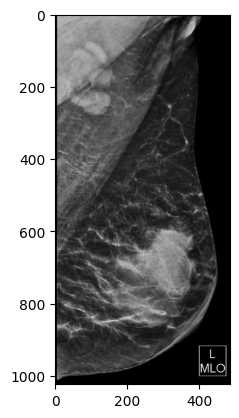

In [ ]:
img = Image.open('/content/breast.jpg')
plt.imshow(img, cmap = 'gray')

perform K mean for segmentation

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


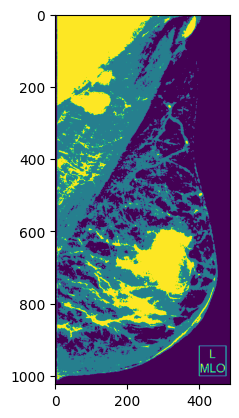

In [ ]:
# from skimage import io
from sklearn import cluster

# img.show()
img = np.array(img)
h, w = img.shape

# reshape to 1D array
image_1d = img.reshape(h*w,1)

# set number of colors
k = 3

# do kmeans processing
kmeans_cluster = cluster.KMeans(n_clusters=int(k))
kmeans_cluster.fit(image_1d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# need to scale result back to range 0-255
segmented_image = cluster_centers[cluster_labels].reshape(h, w)
segmented_image = segmented_image.astype('uint8')

# display result
plt.imshow(segmented_image)

The segmentation isn't smooth so try to use Gaussian for blur image a little bit

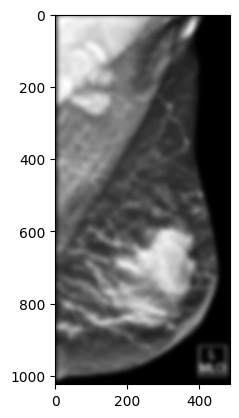

In [ ]:
# GaussianBlur image
img = cv2.imread('/content/breast.jpg',0)
blurImg = cv2.GaussianBlur(img,(41,41), 0)
plt.imshow(blurImg, cmap='gray')

perform K mean for segmentation again after smooth image

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(-0.5, 483.5, 1023.5, -0.5)

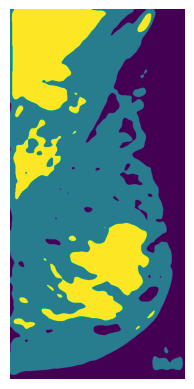

In [ ]:
from skimage import io
from sklearn import cluster

# Get W,H from img array
blurImg = np.array(blurImg)
h, w = blurImg.shape

# reshape to 1D array
image_1d = blurImg.reshape(h*w,1)

# set number of colors
k = 3

# do kmeans processing
kmeans_cluster = cluster.KMeans(n_clusters=int(k), random_state=6536115)
kmeans_cluster.fit(image_1d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# need to scale result back to range 0-255
segmented_image = cluster_centers[cluster_labels].reshape(h, w)
segmented_image = segmented_image.astype('uint8')

# display result
plt.imshow(segmented_image)

In [ ]:
from skimage.measure import label, regionprops, regionprops_table

In [ ]:
# Use label for each connected component in the segmented image
label_mask = label(segmented_image)

# Get the properties of each labeled region
regions = regionprops(label_mask)

# Number of regions (excluding background, label 0)
num_regions = len(regions)

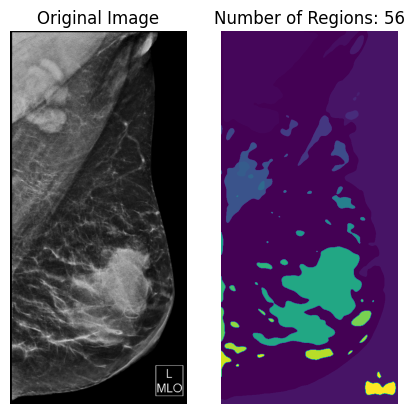

In [ ]:
# Plot the binary image and display the number of regions
plt.figure(figsize=(5, 5))

# Display the binary image
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display the number of regions found
plt.subplot(1, 2, 2)
plt.imshow(label_mask)
plt.title(f'Number of Regions: {num_regions}')
plt.axis('off')

plt.show()


In [ ]:
# Create function for add label number per each centroid origin
def addText2Img(image, org):
  # font
  font = cv2.FONT_HERSHEY_SIMPLEX

  # fontScale
  fontScale = 1

  # color in BGR
  color = (255, 255, 255)

  # Line thickness of 2 px
  thickness = 2

  # Using cv2.putText() method
  image = cv2.putText(image, str(i+1), org, font,
                    fontScale, color, thickness, cv2.LINE_AA)
  return image

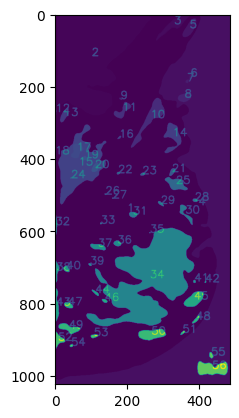

In [ ]:
label_mask_int = label_mask.astype('uint8')
labelNum = np.zeros(label_mask.shape)

# Calculate the prop of the labeled image
prop = regionprops_table(label_mask, properties=('label',
                                                 'area',
                                                 'centroid',
                                                 'equivalent_diameter',
                                                 'orientation',
                                                 'perimeter',
                                                 'axis_major_length',
                                                 'axis_minor_length'))

# For loop over the centroids and annotate the image with the label number
for i in range(prop['centroid-0'].shape[0]):
    labelNum = addText2Img(image = labelNum, org = (int(prop['centroid-1'][i]), int(prop['centroid-0'][i])))

# Display the image
plt.imshow(label_mask + 0.07 * labelNum)

Display area label 34 for tumor region

The output should show the colored of the tumor area and its size of the tumor in pixel.

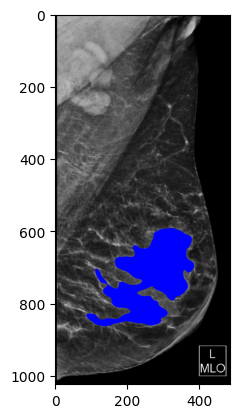

In [ ]:
img = Image.open('/content/breast.jpg')
img = np.array(img)
img_temp = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Assign blue RGB color for label 34
img_temp[label_mask == 34] = [0, 0, 255]

plt.imshow(img_temp, cmap = 'gray')

In [ ]:
df = pd.DataFrame(prop)
df

,label,area,centroid-0,centroid-1,equivalent_diameter,orientation,perimeter,axis_major_length,axis_minor_length
0,1,253963,546.074267,199.405091,568.643768,-0.101334,9612.435672,1044.314908,451.603286
1,2,46918,115.448399,101.546613,244.413283,-0.400803,1138.950360,324.212359,217.339021
2,3,1897,27.882446,329.822351,49.146062,-0.937255,269.847763,113.923887,24.611516
3,4,117991,528.709419,396.872041,387.596191,-0.098505,3835.772870,1361.259445,310.958101
4,5,1085,38.697696,372.367742,37.168063,-0.559291,145.195959,61.830002,22.631124
5,6,56,172.732143,374.625000,8.444016,-0.528625,28.142136,12.216986,5.945360
6,7,64,185.671875,365.296875,9.027033,-0.700321,28.142136,10.760488,7.653698
7,8,675,230.503704,358.022222,29.316151,-1.285221,100.083261,37.591687,23.065652
8,9,39,234.076923,181.589744,7.046726,1.033610,21.899495,9.419851,5.278578
9,10,2930,287.868601,264.019113,61.078571,-0.573367,370.859956,166.097773,34.150818


In [ ]:
df[df['label'] == 34]

,label,area,centroid-0,centroid-1,equivalent_diameter,orientation,perimeter,axis_major_length,axis_minor_length
33,34,38915,730.559424,262.763073,222.594063,-0.698681,1708.007322,331.649849,191.062334


In [ ]:
print('Size of the tumour in pixel :',df[df['label'] == 34]['area'].values[0])

Size of the tumour in pixel : 38915
